# implot

In [2]:
# Imports gerais
import matplotlib.pyplot as plt
import numpy as np

# Pré processamento de dados
from sklearn.preprocessing import MinMaxScaler

# Métricas
from sklearn.metrics import accuracy_score          # Acurácia
from sklearn.metrics import r2_score                # R2
from sklearn.metrics import mean_squared_error      # MSE

In [3]:
#Plot configs
plt.rcParams["figure.figsize"] = (18,6)

In [4]:
def classificate_movs(predicted: list) -> list:
    """
    Compara os valores previstos com os valores reais de fechamento e gera 
    classificações de subida ou queda.

    Params:
        list predicted: lista com os valores previstos

    Returns:
        list pred_movs: lista com os movimentos, sendo o primeiro elemento None
    """

    pred_movs = []

    for i in range(len(predicted)-1):
        if predicted[i+1] > predicted[i]:
            pred_movs.append("Up")
        elif predicted[i+1] < predicted[i]:
            pred_movs.append("Down")
        else:
            pred_movs.append("Up")

    pred_movs.append(None)
    return pred_movs

In [5]:
def save_data(*data, 
              labels: list, 
              model: str, 
              dictionary: dict) -> dict:

    """Função que salva em um dicionário dados específicos, 
    cujas labels das linhas são passados em uma lista 
    (parâmetro labels).

    Params:
        *data: dados a serem salvados
        labels: labels que correspondem às métricas utilizadas
        model: modelo em questão, que será alocado na coluna
        dictionary: variável utilizada para armazenar os dados

    Returns:
        dictionary: mesmo dicionário passado no parâmetro, porém
        atualizado com os dados.
    """

    dictionary[model] = {}
    for l, i in zip(labels, data):
        dictionary[model][l] = i

    print(f"{model} Salvado com sucesso!")
    return dictionary

In [6]:
def classifications_trading(closes: list, 
                            predicted_movements: list,
                            model: str,
                            n: int = 1500,
                            wallet: float = 100000.00,
                            show_results=False) -> list:
    
    """
    Algoritmo para realizar operações de trading com base em movimentos diários
    previstos para uma ação em um determinado intervalo temporal.

    Algoritmo:
        A partir do PRIMEIRO DIA até o ÚLTIMO DIA:
            Se o close previsto hoje para AMANHÃ É ALTA e ontem para HOJE É ALTA:
                Se comprado:
                    MANTER COMPRADO
                Se não comprado:
                    COMPRAR HOJE próximo do fechamento
            Se o close previsto hoje para AMANHÃ É BAIXA:
                Se comprado:
                    VENDER HOJE próximo do fechamento
                Se não comprado:
                    MANTER SEM COMPRAR

    Params:
        closes: valores reais de fechamento de uma ação
                predicted_movements: movimentos previstos, com base nos preços de 
                fechamento
        previstos por um modelo preditivo
        model: nome do modelo utilizado nas previsões
        n: número de ações compradas em cada negociação. Por padrão, é 1500 unidades
        wallet: valor inicial da carteira disponível para negociações. Por padrão,
                é inicialmente R$ 100.000,00
        show_results: caso True, exibe os resultados através da função 
                      'show_operation_results'. Por padrão, Falso.
    
    Returns:
        Retorna uma lista com métricas específicas após a finalização da operação
        de trading. Acerca das métricas presentes na lista, são elas:

        model: nome do modelo preditivo;
        initial_wallet: valor da carteira inicial;
        wallet: valor da carteira final, após as operações;
        walls_diff: diferença numérica entre as carteiras inicial e final;
        walls_percent_diff: diferença percentual entre as carteiras inicial e final;
        score: número de operações com lucro;
        loss: número de operações com prejuízo;
        accuracy: acurácia das operações com lucro;
        mean_gain: ganho médio nas operações com lucro;
        [buys, sells, gains]: respectivamente: lista com compras, vendas e ganhos (BRL)
    """

    # Inicialização das variáveis
    initial_wallet = wallet
    sells = []
    buys = []
    gains = []
    buyed = False

    score = 0
    loss = 0

    for i in range(0, len(closes)):                              # Para todos os dias, do segundo ao último:
        if i == len(closes) - 1:
            wallet += last_buy                                   # Junta as quantias
            buys.append(np.nan)
            sells.append(np.nan)
            gains.append(np.nan)
        if predicted_movements[i] == "Up":                       # Se o close previsto de hoje for de alta:
            if buyed:                                            # Se já esta comprado:
                buys.append(np.nan)
                sells.append(np.nan)
                gains.append(np.nan)
                continue                                         # Mantém comprado
            else:                                                # Se não esta comprado:
                if wallet > closes[i]*n:                         # E se tiver dinheiro pra comprar:
                    wallet -= closes[i]*n                        # Compra uma ação
                    buyed = True
                    buys.append(closes[i])
                    sells.append(np.nan)
                    gains.append(np.nan)
                    last_buy = closes[i]*n
        elif predicted_movements[i] == "Down":                  # Se o close previsto de hoje for de baixa:
            if buyed:                                           # Se já esta comprado:
                if wallet > closes[i]*n:                        # Se tiver ações na carteira:
                        wallet += closes[i]*n                   # Vende uma ação
                        buyed = False
                        sells.append(closes[i])
                        buys.append(np.nan)
                        gains.append(closes[i]*n - last_buy)
                        if gains[-1] > 0:
                            score += 1
                        else:
                            loss += 1
                        last_buy = 0
                else:
                    buys.append(np.nan)
                    sells.append(np.nan)
                    gains.append(np.nan)
            else:                                               # Se não esta comprado
                buys.append(np.nan)
                sells.append(np.nan)
                gains.append(np.nan)
                continue                                        # Mantém sem comprar

    walls_diff = wallet - initial_wallet
    walls_percent_diff = wallet / initial_wallet
    accuracy = score / (score + loss)
    n_gains = [i for i in gains if isinstance(i, np.float64)]
    mean_gain = sum(n_gains) / len(n_gains)

    # Lista de retorno com as métricas
    returns = [
        model,
        initial_wallet,
        wallet,
        walls_diff,
        walls_percent_diff,
        score,
        loss,
        accuracy,
        mean_gain,
        [buys, sells, gains]]

    if show_results == True:
        show_operation_results(returns)

    return returns

In [7]:
def show_operation_results(r: list) -> None:
    """
    Exibe os resultados das métricas após uma operação de trading

    Params:
        r: lista com as métricas de saída da função 'classifications_trading'

    Returns:
        None
    """

    print("-" *2**6)
    
    print("+" + ("-" * len(r[0])) + "--+")
    print(f"| {r[0]} |")
    print("+" + ("-" * len(r[0])) + "--+")

    print(f"Initial Wallet: {r[1]}")
    print(f"Final Wallet: {r[2]}")
    print(f"Wallets Diff: {r[3]}")
    print(f"Percentage Wallets diff: {r[4]}")
    print(f"Score: {r[5]}")
    print(f"Loss: {r[6]}")
    print(f"Hits Accuracy: {r[7]}")
    print(f"Mean Gain: {r[8]}")
    print("-" *2**6)

In [8]:
def operation_plot(
        actual_prices,
        buys_sells,
        model,
        predicted_prices=None):
    
    """
    Realiza a plotagem visual das compras e vendas de uma determinada
    operação de trading.

    Params:
        actual_prices: preços reais de fechamentos de uma determinada ação
        buys_sells: último elemento da lista de retorno da função
                    'classifications_trading', após a operação
        model: nome do modelo preditivo
        predicted_prices: lista de preços previstos pelo modelo no período
                          em questão.

    Returns:
        None
    """

    # Preços reais
    plt.plot(range(len(buys_sells[0])), 
             actual_prices, 
             color='orange', 
             label='Close PETR4.SA')
    
    # Preços previstos
    plt.plot(range(len(buys_sells[0])), 
             predicted_prices, 
             color='lightgreen', 
             alpha=0.8, 
             label='Preços previstos PETR4.SA')
    
    # Compras
    plt.scatter(range(len(buys_sells[0])), 
                buys_sells[0], 
                label="Buy", 
                marker="^", color="green")
    
    # Vendas
    plt.scatter(range(len(buys_sells[0])),
                buys_sells[1], 
                label="Sell", 
                marker="v", 
                color="red")
    
    plt.title(f'Classifications Trading com Previsões {model} - PETR4.SA')
    plt.xlabel('Data (2019)')
    plt.ylabel('Preços (BRL)')
    plt.grid(linestyle="-.")

    plt.legend(['Preço real de fechamento', 
                'Preço de fechamento previsto', 
                "Compra", 
                "Venda"])

    plt.show()

# 用于保存结果的词典

In [9]:
import pandas as pd
from datetime import datetime

# Carregando dados do Drive
dataset = 'data/000028.SZ.xlsx'
df = pd.read_excel(dataset,index_col=0)

In [10]:
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d%H%M%S')
df.index = df['Date'].values
df = df.resample('1min').mean()

In [11]:
# Limpando os dados
# Eliminando linhas com NaN
df = df.dropna()

# Adicionando coluna com movimentos das ações
df_mov = classificate_movs(df.Close.values) # Classificando os movimentos
df["Mov"] = df_mov

df['Date'] = df.index
# Colocando a coluna de data como index da tabela
df.set_index(df.Date, inplace=True)

In [12]:
# Header dos dados
df = df[df['Close'] != 0]
df.head()

,Open,High,Low,Close,monmey,Volume,Mov,Date
Date,,,,,,,,
2022-10-10 09:25:00,29.87,29.54,29.5400,29.5400,1804894.00,611.00,Down,2022-10-10 09:25:00
2022-10-10 09:30:00,29.87,29.54,29.8025,29.5115,3409526.45,1151.50,Down,2022-10-10 09:30:00
2022-10-10 09:31:00,29.87,29.54,29.8400,29.5100,4650960.30,1568.85,Up,2022-10-10 09:31:00
2022-10-10 09:32:00,29.87,29.54,29.9395,29.5100,5984178.85,2015.50,Up,2022-10-10 09:32:00
2022-10-10 09:33:00,29.87,29.54,29.9500,29.5100,6864803.80,2310.40,Up,2022-10-10 09:33:00


In [13]:
# Criando um novo df para as cotações de 2019
tr = df[(df.Date > '2022-10-10 09:25:00') & (df.Date < '2022-10-26 15:00:00')] # Dados de treino (2017 e 2018)
te = df[(df.Date > '2022-10-26 09:25:00') & (df.Date < '2022-10-31 15:00:00')] # Dados de teste (2019)

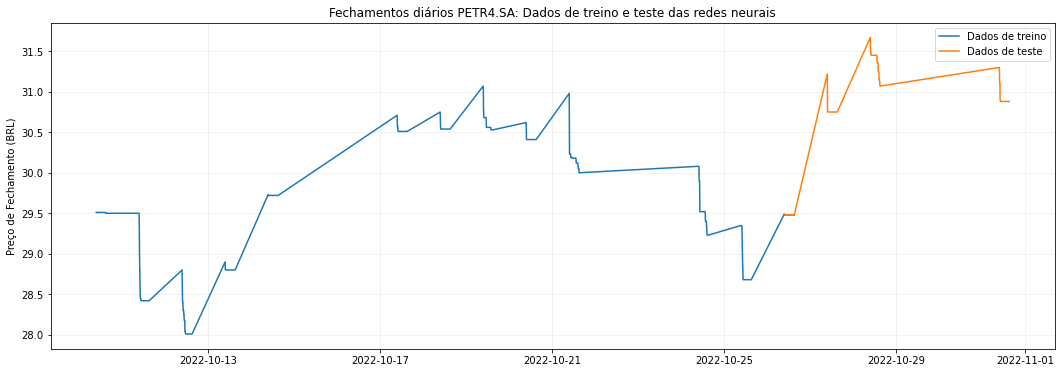

In [14]:
# Visualizando os dados
plt.plot(tr.Close)
plt.plot(te.Close)

# plt.gca().xaxis.set_major_locator(plt.MultipleLocator(20))
# plt.xticks(rotation=90)
plt.ylabel("Preço de Fechamento (BRL)")

plt.title("Fechamentos diários PETR4.SA: Dados de treino e teste das redes neurais")
plt.grid(alpha=.2)

plt.legend(["Dados de treino", "Dados de teste"])

In [15]:
# Dados de Teste
actual_prices = te['Close'].values      # Preços de fechamento (Close)
real_movs = te.Mov.values               # Movimentos dos preços de fechamento (Close)
all_data = pd.concat([tr, te])          # Concatenando os dados de treino e teste

## SMA10, SMA30 & SMA50

In [16]:
# Partindo do conjunto dos dados concatenados para isolar as previsões
# no período de 2019, de maneira comparativa
sma_10 = all_data[-970:].Close.rolling(10).mean() # Média móvel de 10 dias
sma_30 = all_data[-970:].Close.rolling(30).mean() # Média móvel de 30 dias
sma_50 = all_data[-970:].Close.rolling(50).mean() # Média móvel de 50 dias

In [17]:
sma10_class = classificate_movs(sma_10) # Classificando movimentos com base nas previsões SMA10
sma30_class = classificate_movs(sma_30) # Classificando movimentos com base nas previsões SMA30
sma50_class = classificate_movs(sma_50) # Classificando movimentos com base nas previsões SMA50

# Mean Squared Error (MSE) das previsões numéricas
# Partindo da posição onde se excluem os elementos iniciais usados nas SMAs
sma10_mse = ((sma_10[10:] - te.Close.values)**2).mean()
sma30_mse = ((sma_30[30:] - te.Close.values)**2).mean()
sma50_mse = ((sma_50[50:] - te.Close.values)**2).mean()

# Acurácia dos movimentos previstos
# Acurácias calculadas excluindo os valores iniciais das médias móveis
# Excluindo também o último elemento, pois não tem "movimento"
sma10_accuracy = accuracy_score(te.Mov[:-1], sma10_class[10:-1]) # Da posição 10 até a penúltima
sma30_accuracy = accuracy_score(te.Mov[:-1], sma30_class[30:-1]) # Da posição 30 até a penúltima
sma50_accuracy = accuracy_score(te.Mov[:-1], sma50_class[50:-1]) # Da posição 50 até a penúltima

# R2
sma10_r2 = r2_score(te.Close.values, sma_10[10:]) # Da posição 10 até a penúltima
sma30_r2 = r2_score(te.Close.values, sma_30[30:]) # Da posição 30 até a penúltima
sma50_r2 = r2_score(te.Close.values, sma_50[50:]) # Da posição 50 até a penúltima

print("+---------------------------------+")
print("| Resultados SMA10, SMA30 & SMA50 |")
print("+---------------------------------+")

print(f"\nSMA10 MSE: \t\t{sma10_mse}")
print(f"SMA30 MSE: \t\t{sma30_mse}")
print(f"SMA50 MSE: \t\t{sma50_mse}\n")

print(f"\nSMA10 R2: \t\t{sma10_r2}")
print(f"SMA30 R2: \t\t{sma30_r2}")
print(f"SMA50 R2: \t\t{sma50_r2}\n")

print(f"SMA10 Accuracy: \t{sma10_accuracy}")
print(f"SMA30 Accuracy: \t{sma30_accuracy}")
print(f"SMA50 Accuracy: \t{sma50_accuracy}")

ValueError: operands could not be broadcast together with shapes (960,) (970,) 

In [ ]:
# Plotagem de gráfico
te.Close.plot()
sma_10[10:].plot()  # Excluindo primeiros 10 dias usados na SMA10
sma_30[30:].plot()  # Excluindo primeiros 30 dias usados na SMA30
sma_50[50:].plot()  # Excluindo primeiros 50 dias usados na SMA50

plt.title("SMA10 vs SMA30 vs SMA50 vs Preços de Fechamento PETR4.SA")
plt.grid(alpha=.2)
plt.ylabel("Preço (BRL)")

plt.legend(["Close PETR4.SA", "SMA10", "SMA30", "SMA50"])

In [ ]:
# Salvando resultados em um dicionário
models_results = save_data(sma10_accuracy, 
                           sma10_mse, 
                           sma10_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="SMA10", dictionary=models_results) # SMA10

models_results = save_data(sma30_accuracy,
                           sma30_mse, 
                           sma30_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="SMA30", dictionary=models_results) # SMA30

models_results = save_data(sma50_accuracy, 
                           sma50_mse, 
                           sma50_r2, 
                           labels=["Accuracy", "MSE", "R2"],
                           model="SMA50", dictionary=models_results) # SMA50

# 神经网络

In [77]:
# CNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

# LSTM
from tensorflow.keras.models import Sequential as Sequentiall
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [78]:
# Preparando os dados de entrada das redes neurais
scaler = MinMaxScaler(feature_range=(0,3))
scaled_data = scaler.fit_transform(tr['Close'].values.reshape(-1,1))

# Quantidade de dias passados tomados como base para realizar a previsão
prediction_days = 60

nn_x_train = []
nn_y_train = []

for x in range(prediction_days, len(scaled_data)):
    nn_x_train.append(scaled_data[x - prediction_days: x, 0])
    nn_y_train.append(scaled_data[x, 0])
    
nn_x_train, nn_y_train = np.array(nn_x_train), np.array(nn_y_train)
nn_x_train = np.reshape(nn_x_train, (nn_x_train.shape[0], nn_x_train.shape[1], 1))

In [79]:
# Concatenando dados de treino e teste
total_dataset = pd.concat((tr['Close'], te['Close']), axis=0)

model_inputs= total_dataset[len(total_dataset) - len(te) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

# 神经网络CNN

In [80]:
# Declarando o modelo
model = Sequential()

# Camadas da rede
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='sigmoid'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')           # Compilando
model.fit(nn_x_train, nn_y_train, epochs=80, batch_size=60)          # Treinando

Epoch 1/80
52/52 [==============================] - 1s 21ms/step - loss: 0.1326
Epoch 2/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0186
Epoch 3/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0088
Epoch 4/80
52/52 [==============================] - 1s 21ms/step - loss: 0.0060
Epoch 5/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0057
Epoch 6/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0061
Epoch 7/80
52/52 [==============================] - 1s 23ms/step - loss: 0.0044
Epoch 8/80
52/52 [==============================] - 1s 23ms/step - loss: 0.0048
Epoch 9/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0046
Epoch 10/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0043
Epoch 11/80
52/52 [==============================] - 1s 22ms/step - loss: 0.0047
Epoch 12/80
52/52 [==============================] - 1s 28ms/step - loss: 0.0039
Epoch 13/80
52/52 [==================

In [51]:
cnn_x_test = []

for x in range(prediction_days, len(model_inputs)):
    cnn_x_test.append(model_inputs[x - prediction_days: x, 0])

cnn_x_test = np.array(cnn_x_test)
cnn_x_test = np.reshape(cnn_x_test, (cnn_x_test.shape[0], cnn_x_test.shape[1], 1))

# Realizando previsões
cnn_pred_prices = model.predict(cnn_x_test)
cnn_pred_prices = scaler.inverse_transform(cnn_pred_prices)

In [52]:
len(cnn_x_test)

970

In [53]:
# Classificando os movimentos com base nas previsões numéricas
cnn_pred_movs = classificate_movs(cnn_pred_prices)

cnn_accuracy = accuracy_score(te.Mov.values[:-1], cnn_pred_movs[:-1])   # Acurácia dos movimentos 
cnn_r2 = r2_score(actual_prices, cnn_pred_prices)                       # R2 dos movimentos
cnn_mse = mean_squared_error(actual_prices, cnn_pred_prices)            # MSE das previsões

print("+----------------+")
print("| Resultados CNN |")
print("+----------------+")

print(f"\nCNN R2: \t{cnn_r2}")
print(f"CNN MSE: \t{cnn_mse}")
print(f"CNN Accuracy: \t{cnn_accuracy}")

+----------------+
| Resultados CNN |
+----------------+

CNN R2: 	0.9826787244456686
CNN MSE: 	0.008462127944702927
CNN Accuracy: 	0.7141382868937048


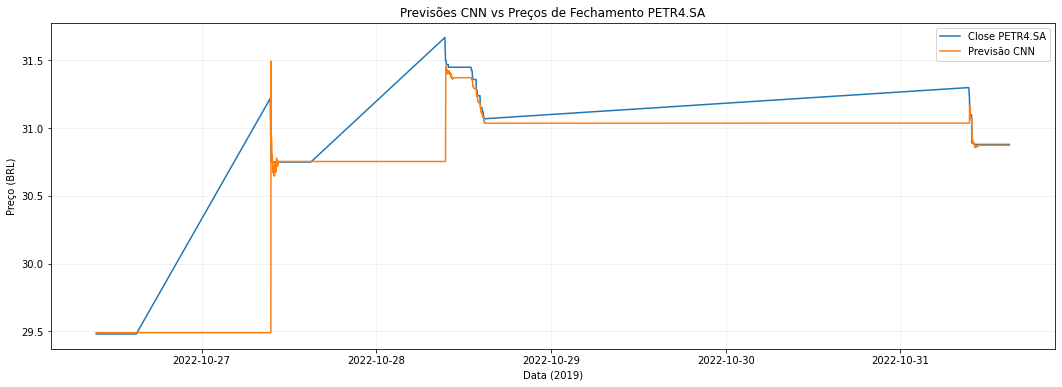

In [54]:
# Plotagem de gráfico
plt.plot(te.index,te.Close)
plt.plot(te.index,cnn_pred_prices)


plt.grid(alpha=.2)
plt.title("Previsões CNN vs Preços de Fechamento PETR4.SA")
plt.legend(["Close PETR4.SA", "Previsão CNN"])
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")

plt.show()

# 神经网络LSTM

In [29]:
# Declarando o modelo
model = Sequentiall()

# Camadas da rede
model.add(LSTM(units=60, return_sequences=True, input_shape=(nn_x_train.shape [1], 1)))
model.add(Dropout(0.1))
model.add(LSTM(units=60, return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units=60))
model.add(Dropout(0.1))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss ='mean_squared_error')           # Compilando
model.fit(nn_x_train, nn_y_train, epochs=60, batch_size=30)           # Treinando  

Epoch 1/60
104/104 [==============================] - 9s 53ms/step - loss: 0.1202
Epoch 2/60
104/104 [==============================] - 6s 55ms/step - loss: 0.0220
Epoch 3/60
104/104 [==============================] - 5s 53ms/step - loss: 0.0195
Epoch 4/60
104/104 [==============================] - 6s 55ms/step - loss: 0.0192
Epoch 5/60
104/104 [==============================] - 6s 54ms/step - loss: 0.0180
Epoch 6/60
104/104 [==============================] - 5s 52ms/step - loss: 0.0160
Epoch 7/60
104/104 [==============================] - 6s 55ms/step - loss: 0.0157
Epoch 8/60
104/104 [==============================] - 5s 52ms/step - loss: 0.0158
Epoch 9/60
104/104 [==============================] - 5s 52ms/step - loss: 0.0141
Epoch 10/60
104/104 [==============================] - 6s 56ms/step - loss: 0.0169
Epoch 11/60
104/104 [==============================] - 6s 54ms/step - loss: 0.0152
Epoch 12/60
104/104 [==============================] - 5s 53ms/step - loss: 0.0132
Epoch 13/60
1

In [30]:
lstm_x_test = []

for x in range(prediction_days, len(model_inputs)):
    lstm_x_test.append(model_inputs[x - prediction_days: x, 0])

lstm_x_test = np.array(lstm_x_test)
lstm_x_test = np.reshape(lstm_x_test, (lstm_x_test.shape[0], lstm_x_test.shape[1], 1))

# Realizando previsões
lstm_pred_prices = model.predict(lstm_x_test)
lstm_pred_prices = scaler.inverse_transform(lstm_pred_prices)

In [31]:
# Classificando os movimentos com base nas previsões numéricas
lstm_pred_movs = classificate_movs(lstm_pred_prices)

lstm_accuracy = accuracy_score(te.Mov.values[:-1], lstm_pred_movs[:-1])     # Acurácia dos movimentos
lstm_r2 = r2_score(actual_prices, lstm_pred_prices)                         # R2 dos movimentos
lstm_mse = mean_squared_error(actual_prices, lstm_pred_prices)              # MSE das previsões

print("+-----------------+")
print("| Resultados LSTM |")
print("+-----------------+")

print(f"\nLSTM R2: \t{lstm_r2}")
print(f"LSTM MSE: \t{lstm_mse}")
print(f"LSTM Accuracy: \t{lstm_accuracy}")

+-----------------+
| Resultados LSTM |
+-----------------+

LSTM R2: 	0.8832203630731295
LSTM MSE: 	0.057051469789938226
LSTM Accuracy: 	0.7708978328173375


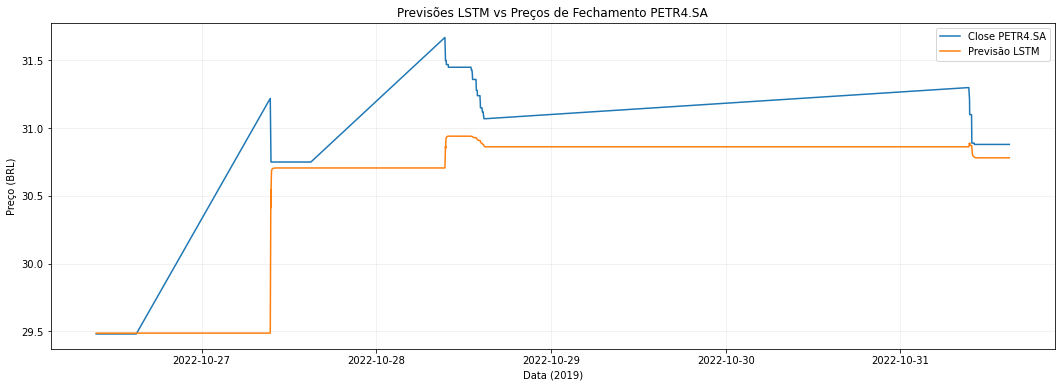

In [34]:
# Plotagem de gráfico
plt.plot(te.index,te.Close)
plt.plot(te.index,lstm_pred_prices)

plt.grid(alpha=.2)
plt.title("Previsões LSTM vs Preços de Fechamento PETR4.SA")
plt.legend(["Close PETR4.SA", "Previsão LSTM"])
plt.ylabel("Preço (BRL)")
plt.xlabel("Data (2019)")

plt.show()